In [1]:
get_ipython().magic('matplotlib inline')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from forward_selection import forward_selected
from backward_selection import backward_selected
sns.set_style('white')
sns.set_context('notebook')

data=pd.read_excel('caschool.xlsx.xls')

state=440232650+470353886+470352982 # sum of the student IDs for the members of the group

train = data.sample(frac=0.8, random_state=state) # For tasks 1-5 
test = data[data.index.isin(train.index)==False].copy() # Only for prediction (task 6)

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

## model 1: the full linear model

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
formula="testscr ~ str + enrl_tot + teachers + computer + expn_stu + el_pct + meal_pct + calw_pct + avginc + comp_stu"
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     152.9
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.87e-116
Time:                        14:59:12   Log-Likelihood:                -1172.8
No. Observations:                 336   AIC:                             2368.
Df Residuals:                     325   BIC:                             2410.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    653.8850     10.567     61.879      0.000     633.096     674.674
str           -0.0390      0.349     -0.112      0.911      -0.725       0.647
enrl_tot       0.0004      0.002      0.206      0.837      -0.003       0.004
teachers      -0.0141      0.039     -0.361      0.718      -0.091       0.063
computer       0.0035      0.003      1.041      0.299      -0.003       0.010
expn_stu       0.0022      0.001      2.264      0.024       0.000       0.004
el_pct        -0.1692      0.038     -4.443      0.000      -0.244      -0.094
meal_pct      -0.4092      0.039    -10.590      0.000      -0.485      -0.333
calw_pct      -0.0523      0.061     -0.851      0.396      -0.173       0.069
avginc         0.5548      0.097      5.744      0.000       0.365       0.745
comp_stu      14.5673      8.286      1.758      0.080      -1.735      30.869
==============================================================================
Omnibus:                       10.580   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               19.312
Skew:                          -0.110   Prob(JB):                     6.40e-05
Kurtosis:                       4.154   Cond. No.                     1.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
features = train[['str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']]
features = sm.add_constant(features)  
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(10): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[2.3153446825276358, 271.95875393548209, 315.36195766339114, 12.149967883732289, 2.075466204455183, 2.4105000511944992, 5.6921844813470486, 2.6265455951123466, 2.4574717864797577, 1.463130604333535]


In [4]:
# average VIF
np.mean(vif)

61.851132288805545

In [5]:
ols1.mse_resid**0.5# SER

8.0705401413184408

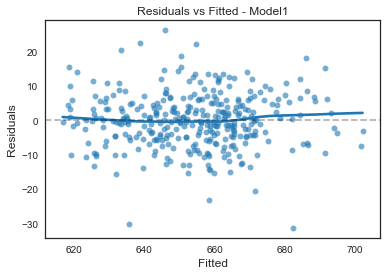

In [6]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model1') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

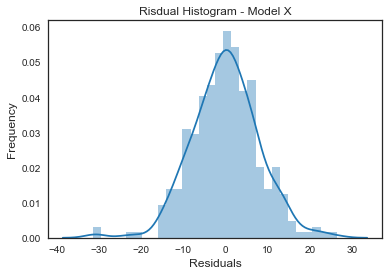

In [7]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [8]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336, minmax=(-31.331762647730557, 26.291896097263361), mean=-2.6736708085601484e-12, variance=63.189331063001468, skewness=-0.11018925901528864, kurtosis=1.153632771860857)

NameError: name 'lowess' is not defined

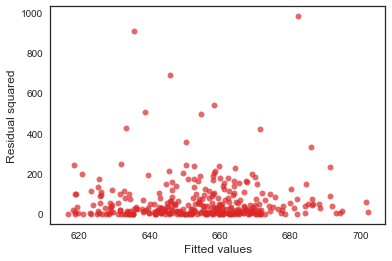

In [9]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

## Model 2: optimised linear model from forward selection

In [11]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [12]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']], 'testscr', nominated=['str'] )
    


you nominated variable(s) ['str'], the adj_r2 is: 0.049352
adding meal_pct increases adj_r2 from 0.049352 to 0.782474
adding avginc increases adj_r2 from 0.782474 to 0.802119
adding el_pct increases adj_r2 from 0.802119 to 0.814721
adding comp_stu increases adj_r2 from 0.814721 to 0.818543
adding expn_stu increases adj_r2 from 0.818543 to 0.820527
final model is testscr ~ str + meal_pct + avginc + el_pct + comp_stu + expn_stu + 1, with adj_r2 of 0.820527


In [70]:

formula= 'testscr ~ str+ meal_pct + avginc + el_pct'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     369.3
Date:                Tue, 31 Oct 2017   Prob (F-statistic):          1.25e-120
Time:                        19:26:31   Log-Likelihood:                -1180.1
No. Observations:                 336   AIC:                             2370.
Df Residuals:                     331   BIC:                             2389.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    675.9318      5.712    118.341      0.000     664.696     687.168
str           -0.5367      0.244     -2.196      0.029      -1.017      -0.056
meal_pct      -0.4183      0.030    -14.142      0.000      -0.476      -0.360
avginc         0.6491      0.090      7.181      0.000       0.471       0.827
el_pct        -0.1698      0.035     -4.856      0.000      -0.239      -0.101
==============================================================================
Omnibus:                        9.654   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.212
Skew:                          -0.130   Prob(JB):                     0.000302
Kurtosis:                       4.044   Cond. No.                         768.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# 2. VIF

features = train[['meal_pct','avginc','el_pct', 'str']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[3.2518654363717441, 2.0990508134424326, 1.9805179397548611, 1.1084173320591357]


In [14]:
np.mean(vif)

2.1099628804070432

In [52]:
ols1.mse_resid**0.5 # SER

8.2192216893431915

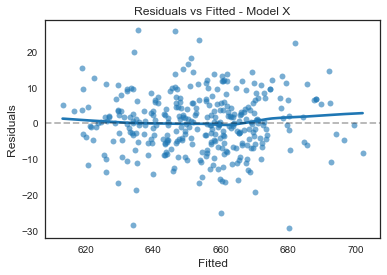

In [54]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model X') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

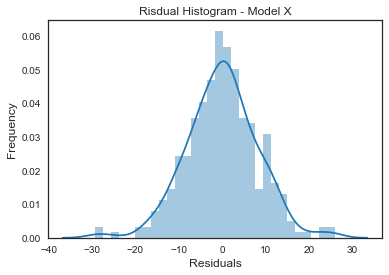

In [56]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [58]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336, minmax=(-29.275442939603522, 25.959417426165828), mean=-1.2552921665095104e-13, variance=66.950629609806228, skewness=-0.06986083864847821, kurtosis=0.8883288343920723)

NameError: name 'lowess' is not defined

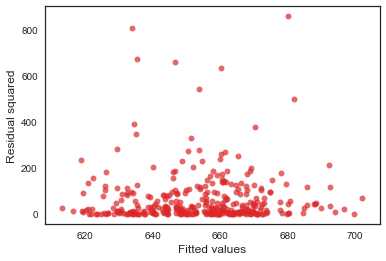

In [60]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

Note about backward seletion: it gives us the exact same model


In [61]:
def backward_selected(data, response, nominated = []):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    if nominated:
        print("you nominated variables %s" %nominated)
    nominated = set(nominated)
    remaining^=nominated
    formula = "{} ~ {} + 1".format(response,' + '.join(remaining | nominated))
    current_score = smf.ols(formula, data).fit().rsquared_adj
    print("adj_r2 if all variables included: %f" %current_score)
    best_new_score = current_score
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(remaining^{candidate}|nominated))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("deleting %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(remaining|nominated))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [62]:
model3 = backward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']], 'testscr', nominated=[] )


adj_r2 if all variables included: 0.819307
deleting str increases adj_r2 from 0.819307 to 0.819854
deleting enrl_tot increases adj_r2 from 0.819854 to 0.820389
deleting teachers increases adj_r2 from 0.820389 to 0.820547
deleting computer increases adj_r2 from 0.820547 to 0.820810
deleting calw_pct increases adj_r2 from 0.820810 to 0.821069
final model is testscr ~ el_pct + expn_stu + comp_stu + avginc + meal_pct + 1, with adj_r2 of 0.821069


## Model 3 - from the model from FS, we add in one interaction term of student teacher ratio:English learners percent 

In [17]:
train.loc[(train['str'] >= 21),'cat_str'] = '2'
train.loc[(train['str'] <21) & (train['str'] >17),'cat_str'] = '1'
train.loc[(train['str'] <= 17),'cat_str'] = '0'


train["high_str"] = np.where(train["cat_str"]=="2",1,0)
train["med_str"] = np.where(train["cat_str"]=="1",1,0)
train["low_str"] = np.where(train["cat_str"]=="0",1,0)
train.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,expn_stu,str,avginc,el_pct,read_scr,math_scr,cat_str,high_str,med_str,low_str
0,357,70995,Sonoma,Waugh Elementary,KK-06,734,36.000000,2.0243,12.820500,117,...,4920.777344,20.388889,16.955999,6.539509,676.099976,669.299988,1,0,1,0
1,15,72298,Tulare,Woodville Elementary,KK-08,649,36.000000,14.6379,76.271202,31,...,5621.456055,18.027779,9.630000,80.123260,611.900024,621.000000,1,0,1,0
2,60,72561,Ventura,Rio Elementary,KK-08,3074,142.550003,11.2898,66.194901,249,...,5034.290039,21.564363,11.592000,38.158752,633.200012,632.500000,2,1,0,0
3,259,72207,Tulare,Three Rivers Union Elementary,KK-08,248,11.120000,7.4627,21.268700,51,...,4302.834961,22.302158,15.365000,0.000000,667.799988,652.799988,2,1,0,0
4,246,63024,Humboldt,Scotia Union Elementary,KK-08,370,19.799999,6.5041,36.314400,56,...,4385.229492,18.686869,12.174000,0.540541,664.000000,652.700012,1,0,1,0


In [18]:
train['lowstr_el'] =train['low_str'] * train['el_pct']
train['medstr_el'] = train['med_str'] * train['el_pct']
train['highstr_el'] = train['high_str'] * train['el_pct']

train['str_el'] = train['el_pct'] * train['str']


In [19]:
formula='testscr ~ str + meal_pct + avginc + el_pct + str_el'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     294.9
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          2.11e-119
Time:                        15:57:32   Log-Likelihood:                -1179.9
No. Observations:                 336   AIC:                             2372.
Df Residuals:                     330   BIC:                             2395.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    678.4710      7.042     96.349      0.000     664.618     692.324
str           -0.6571      0.313     -2.100      0.036      -1.273      -0.042
meal_pct      -0.4208      0.030    -14.075      0.000      -0.480      -0.362
avginc         0.6423      0.091      7.045      0.000       0.463       0.822
el_pct        -0.3438      0.284     -1.211      0.227      -0.902       0.215
str_el         0.0088      0.014      0.618      0.537      -0.019       0.037
==============================================================================
Omnibus:                       10.168   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.108
Skew:                          -0.148   Prob(JB):                     0.000193
Kurtosis:                       4.065   Cond. No.                     7.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
features = train[['str','avginc','el_pct', 'meal_pct','low_str', 'med_str' ,'high_str', 'lowstr_el', 'medstr_el', 'highstr_el']] 
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(9): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[2.1319605550930132, inf, 3.2998310044826944, 29.145703407678063, 291.61779474666241, 124.7195927924359, inf, inf, inf]


C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [172]:
ols1.mse_resid**0.5

8.1680846136915211

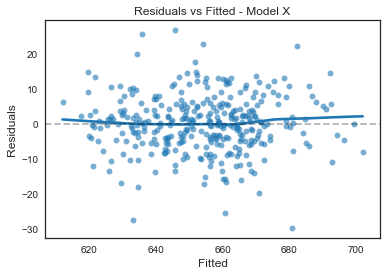

In [174]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model X') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

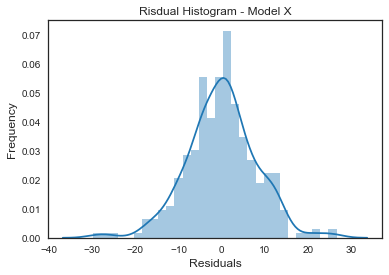

In [176]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [178]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336, minmax=(-29.751804459078585, 26.640469302250153), mean=-2.3789647500615544e-12, variance=65.323507021215292, skewness=-0.07697812923054072, kurtosis=1.0483561132196888)

NameError: name 'lowess' is not defined

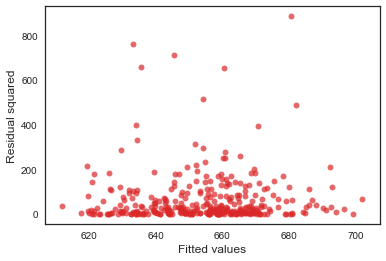

In [180]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

## Model 4: interaction term between expenditure per student and Calworks percent 

In [35]:
train.loc[(train['calw_pct'] >= 30),'cat_calw'] = '2'
train.loc[(train['calw_pct'] < 30) & (train['calw_pct'] > 15),'cat_calw'] = '1'
train.loc[(train['calw_pct'] <= 15),'cat_calw'] = '0'


train["high_calw"] = np.where(train["cat_calw"]=="2",1,0)
train["med_calw"] = np.where(train["cat_calw"]=="1",1,0)
train["low_calw"] = np.where(train["cat_calw"]=="0",1,0)
train.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,med_str,low_str,lowstr_el,medstr_el,highstr_el,round_comp_stu,cat_meal,high_meal,med_meal,low_meal
0,357,70995,Sonoma,Waugh Elementary,KK-06,734,36.000000,2.0243,12.820500,117,...,1,0,0.0,6.539509,0.000000,0.2,0,0,0,1
1,15,72298,Tulare,Woodville Elementary,KK-08,649,36.000000,14.6379,76.271202,31,...,1,0,0.0,80.123260,0.000000,0.0,2,1,0,0
2,60,72561,Ventura,Rio Elementary,KK-08,3074,142.550003,11.2898,66.194901,249,...,0,0,0.0,0.000000,38.158752,0.1,2,1,0,0
3,259,72207,Tulare,Three Rivers Union Elementary,KK-08,248,11.120000,7.4627,21.268700,51,...,0,0,0.0,0.000000,0.000000,0.2,0,0,0,1
4,246,63024,Humboldt,Scotia Union Elementary,KK-08,370,19.799999,6.5041,36.314400,56,...,1,0,0.0,0.540541,0.000000,0.2,1,0,1,0


In [12]:
train['lowcalw_stuexp'] = train['low_calw'] * train['expn_stu']
train['medcalw_stuexp'] = train['med_calw'] * train['expn_stu']
train['highcalw_stuexp'] = train['high_calw'] * train['expn_stu']

In [13]:
formula='testscr ~ str +C(cat_calw) + meal_pct + avginc + el_pct + expn_stu + lowcalw_stuexp + medcalw_stuexp + highcalw_stuexp'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     168.0
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          9.19e-117
Time:                        07:55:24   Log-Likelihood:                -1174.8
No. Observations:                 336   AIC:                             2370.
Df Residuals:                     326   BIC:                             2408.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          652.9046     10.366     62.983      0.000     632.511     673.298
C(cat_calw)[T.1]    15.1474      9.847      1.538      0.125      -4.225      34.520
C(cat_calw)[T.2]   -13.0883     17.312     -0.756      0.450     -47.146      20.970
str                 -0.0576      0.310     -0.186      0.853      -0.668       0.553
meal_pct            -0.4358      0.038    -11.444      0.000      -0.511      -0.361
avginc               0.5514      0.097      5.661      0.000       0.360       0.743
el_pct              -0.1693      0.037     -4.609      0.000      -0.242      -0.097
expn_stu             0.0021      0.001      2.152      0.032       0.000       0.004
lowcalw_stuexp       0.0009      0.001      0.830      0.407      -0.001       0.003
medcalw_stuexp      -0.0018      0.001     -1.274      0.204      -0.005       0.001
highcalw_stuexp      0.0030      0.002      1.338      0.182      -0.001       0.007
==============================================================================
Omnibus:                       11.527   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.541
Skew:                          -0.161   Prob(JB):                     3.46e-05
Kurtosis:                       4.168   Cond. No.                     2.38e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.63e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

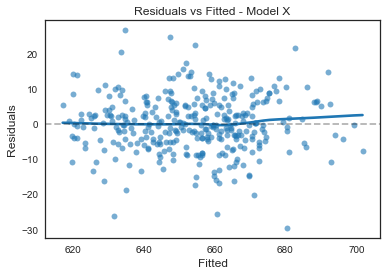

In [22]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model X') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

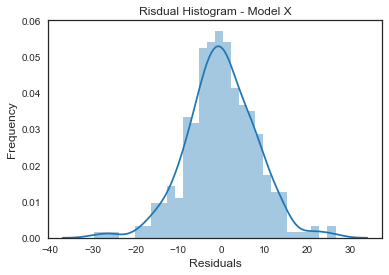

In [24]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [26]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336, minmax=(-29.623168826288975, 26.687137248452359), mean=3.6880551522786153e-13, variance=65.061149356025012, skewness=-0.08058271858992479, kurtosis=0.963668559321254)

NameError: name 'lowess' is not defined

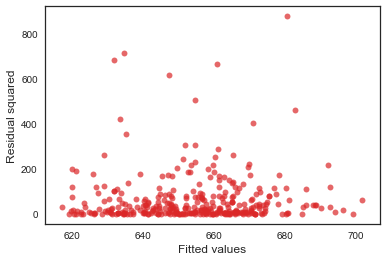

In [28]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

## Model 6- interaction with computers and meal percent

In [47]:

train['round_comp_stu'] = train['comp_stu'].round(1)

train['lowmeal_comp'] = train['low_meal'] * train['comp_stu']
train['medmeal_comp'] = train['med_meal'] * train['comp_stu']
train['highmeal_comp'] = train['high_meal'] * train['comp_stu']



In [48]:

formula='testscr ~ str +C(cat_meal) +comp_stu + avginc + el_pct + lowmeal_comp + medmeal_comp + highmeal_comp'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     144.3
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.82e-102
Time:                        10:42:21   Log-Likelihood:                -1211.5
No. Observations:                 336   AIC:                             2441.
Df Residuals:                     327   BIC:                             2475.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          666.7018      8.412     79.256      0.000     650.153     683.250
C(cat_meal)[T.1]   -13.4447      5.587     -2.407      0.017     -24.435      -2.454
C(cat_meal)[T.2]   -28.8185      5.854     -4.923      0.000     -40.335     -17.302
str                 -0.2868      0.280     -1.023      0.307      -0.838       0.265
comp_stu             8.9486      7.897      1.133      0.258      -6.588      24.485
avginc               0.9127      0.111      8.195      0.000       0.694       1.132
el_pct              -0.3184      0.034     -9.342      0.000      -0.385      -0.251
lowmeal_comp       -23.9056     19.910     -1.201      0.231     -63.073      15.262
medmeal_comp         8.2304     11.210      0.734      0.463     -13.823      30.284
highmeal_comp       24.6239     11.952      2.060      0.040       1.111      48.137
==============================================================================
Omnibus:                       11.303   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.925
Skew:                          -0.237   Prob(JB):                     0.000211
Kurtosis:                       3.992   Cond. No.                     1.96e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.56e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Model 7- interaction with english percent and meal pct 

In [13]:
train.loc[(train['str'] >= 21),'cat_str'] = '2'
train.loc[(train['str'] <21) & (train['str'] >17),'cat_str'] = '1'
train.loc[(train['str'] <= 17),'cat_str'] = '0'


train["high_str"] = np.where(train["cat_str"]=="2",1,0)
train["med_str"] = np.where(train["cat_str"]=="1",1,0)
train["low_str"] = np.where(train["cat_str"]=="0",1,0)
train.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,el_pct,read_scr,math_scr,cat_str,high_str,med_str,low_str,lowstr_expn,medstr_expn,highstr_expn
0,357,70995,Sonoma,Waugh Elementary,KK-06,734,36.000000,2.0243,12.820500,117,...,6.539509,676.099976,669.299988,1,0,1,0,0.0,4920.777344,0.000000
1,15,72298,Tulare,Woodville Elementary,KK-08,649,36.000000,14.6379,76.271202,31,...,80.123260,611.900024,621.000000,1,0,1,0,0.0,5621.456055,0.000000
2,60,72561,Ventura,Rio Elementary,KK-08,3074,142.550003,11.2898,66.194901,249,...,38.158752,633.200012,632.500000,2,1,0,0,0.0,0.000000,5034.290039
3,259,72207,Tulare,Three Rivers Union Elementary,KK-08,248,11.120000,7.4627,21.268700,51,...,0.000000,667.799988,652.799988,2,1,0,0,0.0,0.000000,4302.834961
4,246,63024,Humboldt,Scotia Union Elementary,KK-08,370,19.799999,6.5041,36.314400,56,...,0.540541,664.000000,652.700012,1,0,1,0,0.0,4385.229492,0.000000


In [29]:
train.loc[(train['meal_pct'] >= 50),'cat_meal'] = '2'
train.loc[(train['meal_pct'] < 50) & (train['meal_pct'] > 10),'cat_meal'] = '1'
train.loc[(train['meal_pct'] <= 10),'cat_meal'] = '0'


train["high_meal"] = np.where(train["cat_meal"]=="2",1,0)
train["med_meal"] = np.where(train["cat_meal"]=="1",1,0)
train["low_meal"] = np.where(train["cat_meal"]=="0",1,0)
train.head()

,Observation Number,dist_cod,county,district,gr_span,enrl_tot,teachers,calw_pct,meal_pct,computer,...,highstr_expn,round_comp_stu,cat_meal,high_meal,med_meal,low_meal,lowmeal_stuexp,medmeal_stuexp,highmeal_stuexp,num
0,357,70995,Sonoma,Waugh Elementary,KK-06,734,36.000000,2.0243,12.820500,117,...,0.000000,0.2,1,0,1,0,0.0,6.539509,0.000000,83.839781
1,15,72298,Tulare,Woodville Elementary,KK-08,649,36.000000,14.6379,76.271202,31,...,0.000000,0.0,2,1,0,0,0.0,0.000000,80.123260,6111.097393
2,60,72561,Ventura,Rio Elementary,KK-08,3074,142.550003,11.2898,66.194901,249,...,5034.290039,0.1,2,1,0,0,0.0,0.000000,38.158752,2525.914822
3,259,72207,Tulare,Three Rivers Union Elementary,KK-08,248,11.120000,7.4627,21.268700,51,...,4302.834961,0.2,1,0,1,0,0.0,0.000000,0.000000,0.000000
4,246,63024,Humboldt,Scotia Union Elementary,KK-08,370,19.799999,6.5041,36.314400,56,...,0.000000,0.2,1,0,1,0,0.0,0.540541,0.000000,19.629407


In [14]:
train['lowstr_expn'] =train['low_str'] * train['expn_stu']
train['medstr_expn'] = train['med_str'] * train['expn_stu']
train['highstr_expn'] = train['high_str'] * train['expn_stu']

In [24]:
train['lowmeal_stuexp'] = train['low_meal'] * train['el_pct']
train['medmeal_stuexp'] = train['med_meal'] * train['el_pct']
train['highmeal_stuexp'] = train['high_meal'] * train['el_pct']

In [21]:
formula='testscr ~ C(cat_str) +  avginc + el_pct+lowstr_expn + medstr_expn +highstr_expn'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     114.3
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           4.85e-84
Time:                        09:28:51   Log-Likelihood:                -1257.8
No. Observations:                 336   AIC:                             2532.
Df Residuals:                     328   BIC:                             2562.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         622.5886     16.477     37.785      0.000     590.175     655.002
C(cat_str)[T.1]    23.9795     17.847      1.344      0.180     -11.129      59.089
C(cat_str)[T.2]    14.2130     22.189      0.641      0.522     -29.438      57.864
avginc              1.5035      0.089     16.924      0.000       1.329       1.678
el_pct             -0.4937      0.034    -14.639      0.000      -0.560      -0.427
lowstr_expn         0.0025      0.003      0.936      0.350      -0.003       0.008
medstr_expn        -0.0014      0.001     -1.045      0.297      -0.004       0.001
highstr_expn        0.0002      0.003      0.064      0.949      -0.006       0.006
==============================================================================
Omnibus:                        6.539   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                7.566
Skew:                          -0.205   Prob(JB):                       0.0228
Kurtosis:                       3.611   Cond. No.                     2.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
formula= 'testscr ~ str+ C(cat_meal) + avginc + el_pct + lowmeal_stuexp + medmeal_stuexp + highmeal_stuexp '
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     161.3
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          3.56e-102
Time:                        09:33:52   Log-Likelihood:                -1214.8
No. Observations:                 336   AIC:                             2446.
Df Residuals:                     328   BIC:                             2476.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          665.3498      6.958     95.623      0.000     651.662     679.038
C(cat_meal)[T.1]    -5.2225      3.104     -1.682      0.093     -11.329       0.884
C(cat_meal)[T.2]   -19.1296      3.442     -5.557      0.000     -25.901     -12.358
str                 -0.4873      0.276     -1.765      0.079      -1.030       0.056
avginc               0.9152      0.114      8.047      0.000       0.691       1.139
el_pct              -0.0782      0.143     -0.546      0.586      -0.360       0.204
lowmeal_stuexp       0.4877      0.426      1.146      0.253      -0.350       1.325
medmeal_stuexp      -0.3171      0.153     -2.076      0.039      -0.618      -0.017
highmeal_stuexp     -0.2487      0.146     -1.708      0.089      -0.535       0.038
==============================================================================
Omnibus:                       11.292   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               16.877
Skew:                          -0.237   Prob(JB):                     0.000216
Kurtosis:                       3.990   Cond. No.                     1.74e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
train['num'] = train['meal_pct'] * train['el_pct']
formula= 'testscr ~ str+ meal_pct + avginc + el_pct + num'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     296.8
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          9.11e-120
Time:                        09:37:52   Log-Likelihood:                -1179.0
No. Observations:                 336   AIC:                             2370.
Df Residuals:                     330   BIC:                             2393.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    677.1356      5.764    117.487      0.000     665.798     688.474
str           -0.5385      0.244     -2.207      0.028      -1.019      -0.058
meal_pct      -0.4379      0.033    -13.459      0.000      -0.502      -0.374
avginc         0.6406      0.090      7.082      0.000       0.463       0.818
el_pct        -0.2872      0.089     -3.237      0.001      -0.462      -0.113
num            0.0016      0.001      1.439      0.151      -0.001       0.004
==============================================================================
Omnibus:                       10.851   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               19.338
Skew:                          -0.138   Prob(JB):                     6.32e-05
Kurtosis:                       4.143   Cond. No.                     2.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## model 8- interaction with meal pwc and average income 

In [50]:
train.loc[(train['meal_pct'] >= 50),'cat_meal'] = '2'
train.loc[(train['meal_pct'] < 50) & (train['meal_pct'] > 10),'cat_meal'] = '1'
train.loc[(train['meal_pct'] <= 10),'cat_meal'] = '0'

train["high_meal"] = np.where(train["cat_meal"]=="2",1,0)
train["med_meal"] = np.where(train["cat_meal"]=="1",1,0)
train["low_meal"] = np.where(train["cat_meal"]=="0",1,0)

train['lowmeal_avginc'] = train['low_meal'] * train['avginc']
train['medmeal_avginc'] = train['med_meal'] * train['avginc']
train['highmeal_avginc'] = train['high_meal'] * train['avginc']



In [53]:
formula= 'testscr ~ str+ C(cat_meal)+ avginc + el_pct + expn_stu + lowmeal_avginc + medmeal_avginc + highmeal_avginc '
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     142.5
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          9.34e-102
Time:                        10:44:12   Log-Likelihood:                -1213.2
No. Observations:                 336   AIC:                             2444.
Df Residuals:                     327   BIC:                             2479.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          667.2547     12.230     54.560      0.000     643.196     691.314
C(cat_meal)[T.1]   -18.7959      5.972     -3.147      0.002     -30.544      -7.048
C(cat_meal)[T.2]   -32.6318      6.161     -5.297      0.000     -44.751     -20.512
str                 -0.3000      0.345     -0.870      0.385      -0.979       0.379
avginc               0.7265      0.094      7.712      0.000       0.541       0.912
el_pct              -0.3395      0.034    -10.012      0.000      -0.406      -0.273
expn_stu             0.0010      0.001      0.887      0.376      -0.001       0.003
lowmeal_avginc      -0.0975      0.145     -0.671      0.503      -0.383       0.188
medmeal_avginc       0.3469      0.163      2.133      0.034       0.027       0.667
highmeal_avginc      0.4771      0.221      2.161      0.031       0.043       0.911
==============================================================================
Omnibus:                       13.687   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.678
Skew:                          -0.218   Prob(JB):                     4.38e-06
Kurtosis:                       4.254   Cond. No.                     4.54e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.68e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Forward select as numerical interactions

In [ ]:




model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']], 'testscr', nominated=['str'] )


## model 9- splines 

In [54]:
xi1=train['testscr'].quantile(.2) 
xi2=train['testscr'].quantile(.4)
xi3=train['testscr'].quantile(.6)
xi4=train['testscr'].quantile(.8)
train['Step1']=(train['testscr']>xi1)*(train['testscr']-xi1)
train['Step2']=(train['testscr']>xi2)*(train['testscr']-xi2)
train['Step3']=(train['testscr']>xi3)*(train['testscr']-xi3)
train['Step4']=(train['testscr']>xi4)*(train['testscr']-xi4)

In [115]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [57]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu' ,'Step1', 'Step2', 'Step3', 'Step4']], 'testscr', nominated=[] )
    


adding Step1 increases adj_r2 from 0.000000 to 0.942119
adding Step2 increases adj_r2 from 0.942119 to 0.956350
adding el_pct increases adj_r2 from 0.956350 to 0.960508
adding computer increases adj_r2 from 0.960508 to 0.962284
adding meal_pct increases adj_r2 from 0.962284 to 0.963530
adding Step3 increases adj_r2 from 0.963530 to 0.964087
adding str increases adj_r2 from 0.964087 to 0.964385
adding calw_pct increases adj_r2 from 0.964385 to 0.964592
final model is testscr ~ Step1 + Step2 + el_pct + computer + meal_pct + Step3 + str + calw_pct + 1, with adj_r2 of 0.964592


In [58]:
formula='testscr ~ Step1 + Step2 + el_pct + computer + meal_pct + Step3 + str'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1297.
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          8.98e-235
Time:                        11:15:43   Log-Likelihood:                -901.52
No. Observations:                 336   AIC:                             1819.
Df Residuals:                     328   BIC:                             1850.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    641.2134      2.582    248.313      0.000     636.133     646.293
Step1          1.3838      0.078     17.819      0.000       1.231       1.537
Step2         -0.6633      0.138     -4.792      0.000      -0.936      -0.391
el_pct        -0.0918      0.016     -5.663      0.000      -0.124      -0.060
computer       0.0018      0.000      3.982      0.000       0.001       0.003
meal_pct      -0.0600      0.016     -3.774      0.000      -0.091      -0.029
Step3          0.2070      0.099      2.098      0.037       0.013       0.401
str           -0.2113      0.109     -1.937      0.054      -0.426       0.003
==============================================================================
Omnibus:                      193.481   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.951
Skew:                          -2.182   Prob(JB):                         0.00
Kurtosis:                      14.371   Cond. No.                     7.37e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
features = train[['Step1', 'Step2', 'el_pct', 'computer', 'meal_pct', 'Step3', 'str']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(6): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[41.563047572344246, 80.962430560562609, 2.2165783414034648, 1.1614518942181531, 4.8887249117374187, 22.881610690753117]


In [63]:
np.mean(vif)

25.612307328503167

In [64]:
ols1.mse_resid**0.5 

3.5830335894453915

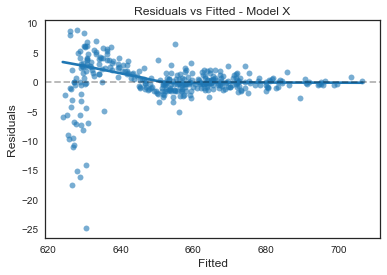

In [65]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model X') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

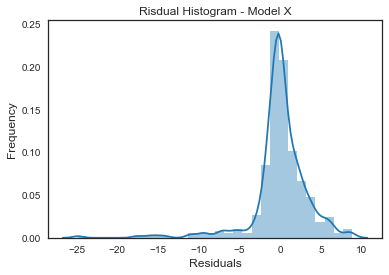

In [66]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [67]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336, minmax=(-24.827208136574882, 8.794379919410062), mean=-2.3955440805626236e-13, variance=12.569870276462114, skewness=-2.1824932409072715, kurtosis=11.371039609777101)

NameError: name 'lowess' is not defined

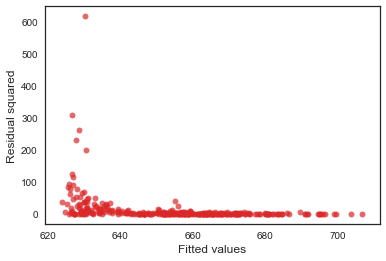

In [68]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

## Model 10- looking at transforming specific transformations of variables 

Computer per students
comp_stu

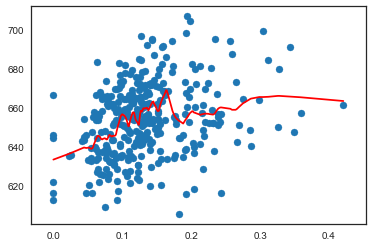

In [125]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['comp_stu'],train['testscr'])
z1 = lowess(train['testscr'],train['comp_stu'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

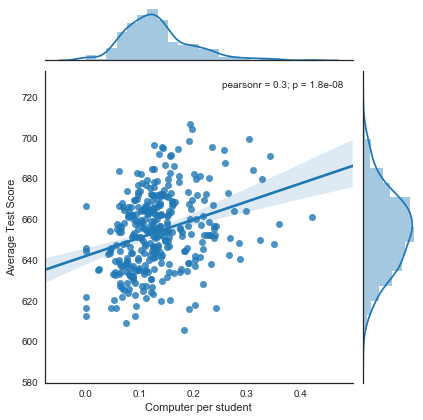

In [126]:
sns.jointplot(x=train['comp_stu'], y=train['testscr'], kind="reg")
plt.ylabel('Average Test Score')
plt.xlabel('Computer per student')
plt.show()

C:\Users\jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


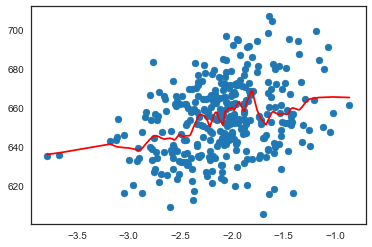

In [127]:
train['log_compstu'] = np.log(train['comp_stu'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_compstu'],train['testscr'])
z1 = lowess(train['testscr'],train['log_compstu'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

expenditure per student 

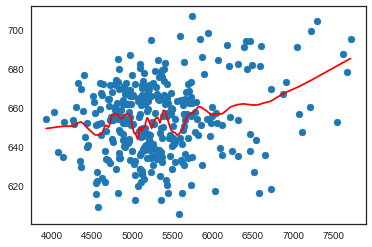

In [128]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['expn_stu'],train['testscr'])
z1 = lowess(train['testscr'],train['expn_stu'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

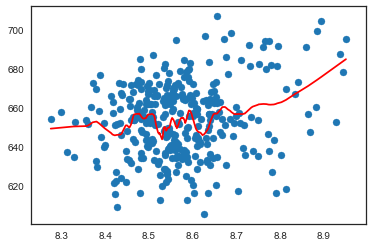

In [129]:
train['log_expnstu'] = np.log(train['expn_stu'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_expnstu'],train['testscr'])
z1 = lowess(train['testscr'],train['log_expnstu'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

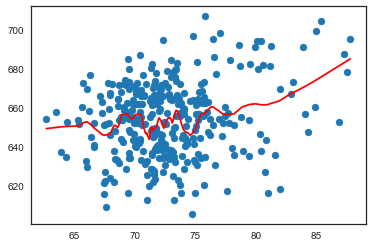

In [130]:
train['stuexp_sqr'] = np.sqrt(train['expn_stu'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['stuexp_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['stuexp_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

Student Teacher Ratio

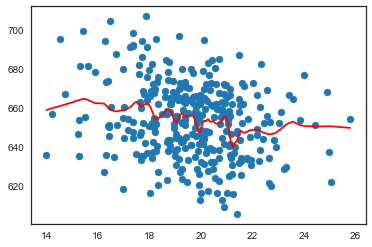

In [131]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['str'],train['testscr'])
z1 = lowess(train['testscr'],train['str'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

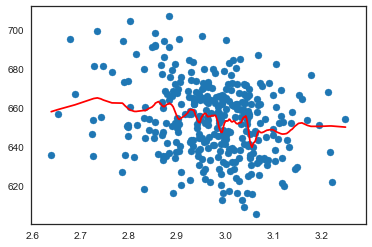

In [132]:
train['log_str'] = np.log(train['str'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_str'],train['testscr'])
z1 = lowess(train['testscr'],train['log_str'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

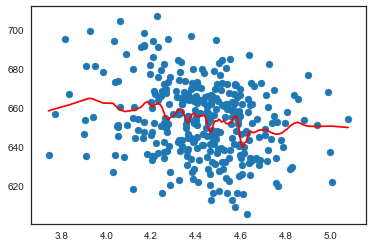

In [133]:
train['str_sqr'] = np.sqrt(train['str'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['str_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['str_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

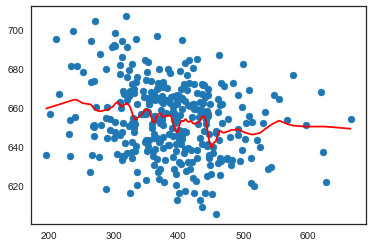

In [134]:
train['str_sq2'] = train['str']**2


import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['str_sq2'],train['testscr'])
z1 = lowess(train['testscr'],train['str_sq2'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

Percent of english learners - transform this to square root, its the best :) 

C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
C:\Users\jasmine\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


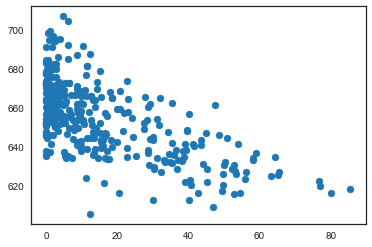

In [22]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['el_pct'],train['testscr'])
z1 = lowess(train['testscr'],train['el_pct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

C:\Users\jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


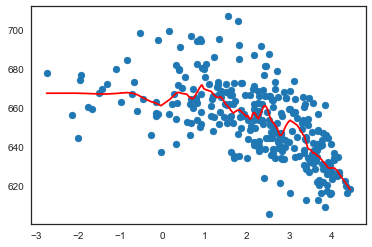

In [136]:
train['log_elpct'] = np.log(train['el_pct'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_elpct'],train['testscr'])
z1 = lowess(train['testscr'],train['log_elpct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
C:\Users\jasmine\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\jasmine\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


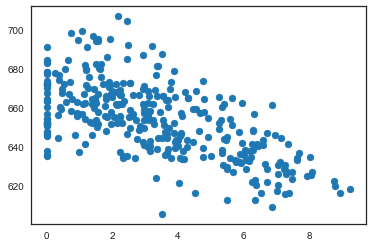

In [137]:
train['elpct_sqr'] = np.sqrt(train['el_pct'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['elpct_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['elpct_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

meal pct

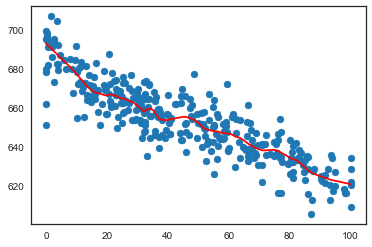

In [138]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['meal_pct'],train['testscr'])
z1 = lowess(train['testscr'],train['meal_pct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

C:\Users\jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


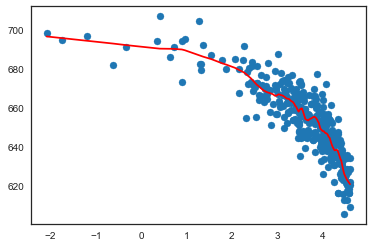

In [139]:
train['log_mealpct'] = np.log(train['meal_pct'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_mealpct'],train['testscr'])
z1 = lowess(train['testscr'],train['log_mealpct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

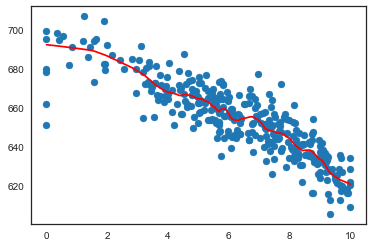

In [140]:
train['meal_sqr'] = np.sqrt(train['meal_pct'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['meal_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['meal_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

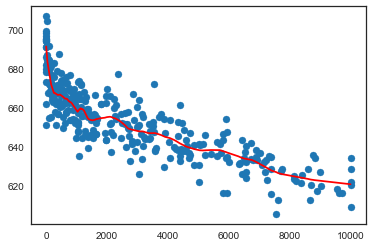

In [141]:
train['mealpct_sq2'] = train['meal_pct']**2


import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['mealpct_sq2'],train['testscr'])
z1 = lowess(train['testscr'],train['mealpct_sq2'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

CALW_PCT

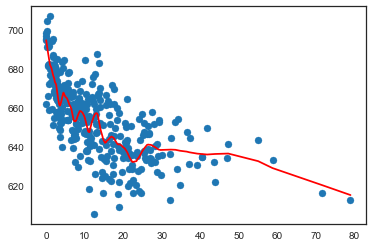

In [142]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['calw_pct'],train['testscr'])
z1 = lowess(train['testscr'],train['calw_pct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

C:\Users\jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


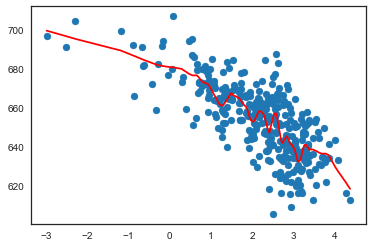

In [143]:
train['log_calwpct'] = np.log(train['calw_pct'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_calwpct'],train['testscr'])
z1 = lowess(train['testscr'],train['log_calwpct'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

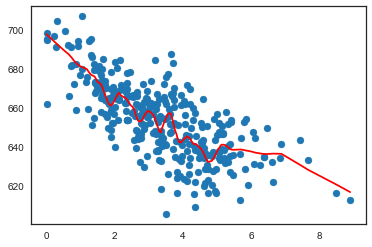

In [144]:
train['calw_sqr'] = np.sqrt(train['calw_pct'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['calw_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['calw_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

average income

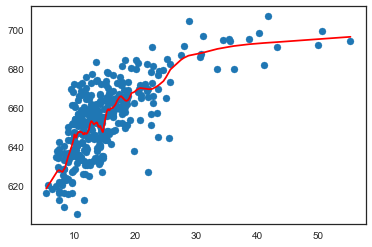

In [145]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['avginc'],train['testscr'])
z1 = lowess(train['testscr'],train['avginc'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

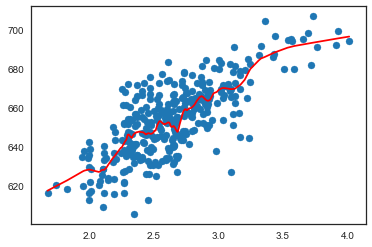

In [146]:
train['log_avginc'] = np.log(train['avginc'])

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['log_avginc'],train['testscr'])
z1 = lowess(train['testscr'],train['log_avginc'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

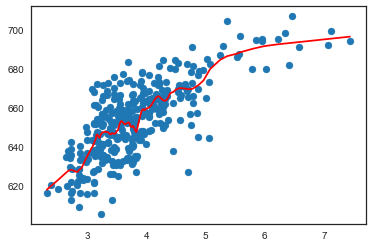

In [147]:
train['avginc_sqr'] = np.sqrt(train['avginc'])
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.scatter(train['avginc_sqr'],train['testscr'])
z1 = lowess(train['testscr'],train['avginc_sqr'], frac=1./10)
plt.plot(z1[:,0],z1[:,1],'red')
plt.show()

In [148]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','elpct_sqr','meal_pct','calw_sqr','log_avginc','comp_stu']], 'testscr', nominated=['str'] )
    


you nominated variable(s) ['str'], the adj_r2 is: 0.049352
adding meal_pct increases adj_r2 from 0.049352 to 0.782474
adding log_avginc increases adj_r2 from 0.782474 to 0.796005
adding elpct_sqr increases adj_r2 from 0.796005 to 0.808735
adding comp_stu increases adj_r2 from 0.808735 to 0.813775
adding expn_stu increases adj_r2 from 0.813775 to 0.816267
adding calw_sqr increases adj_r2 from 0.816267 to 0.817345
final model is testscr ~ str + meal_pct + log_avginc + elpct_sqr + comp_stu + expn_stu + calw_sqr + 1, with adj_r2 of 0.817345


In [149]:
formula='testscr ~ str + meal_pct + log_avginc + elpct_sqr'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     355.1
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          2.39e-118
Time:                        13:34:34   Log-Likelihood:                -1185.4
No. Observations:                 336   AIC:                             2381.
Df Residuals:                     331   BIC:                             2400.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    656.1282      8.472     77.449      0.000     639.463     672.793
str           -0.5821      0.249     -2.339      0.020      -1.072      -0.092
meal_pct      -0.4072      0.033    -12.371      0.000      -0.472      -0.342
log_avginc    11.9826      1.923      6.232      0.000       8.200      15.765
elpct_sqr     -1.3089      0.272     -4.806      0.000      -1.845      -0.773
==============================================================================
Omnibus:                       11.667   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.826
Skew:                          -0.137   Prob(JB):                     1.82e-05
Kurtosis:                       4.218   Cond. No.                     1.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 11 - using no squaroot transformations but the log ones because of better interpretability 